In [1]:
# 아래의 Package가 필요한 경우에 주석을 삭제하고 설치해 주세요.
# 해당 데모는 pytorch-lightning 1.6 버전 이상을 권장합니다.
!pip install sklearn torch "pytorch_lightning>=1.6" livelossplot

  Using cached sklearn-0.0-py2.py3-none-any.whl
  Using cached pytorch_lightning-1.6.5-py3-none-any.whl (585 kB)
  Using cached livelossplot-0.5.5-py3-none-any.whl (22 kB)
  Using cached scikit_learn-1.1.1-cp38-cp38-macosx_10_13_x86_64.whl (8.5 MB)
  Using cached tqdm-4.64.0-py2.py3-none-any.whl (78 kB)
  Using cached torchmetrics-0.9.3-py3-none-any.whl (419 kB)
  Using cached pyDeprecate-0.3.2-py3-none-any.whl (10 kB)
  Using cached fsspec-2022.5.0-py3-none-any.whl (140 kB)
  Using cached tensorboard-2.9.1-py3-none-any.whl (5.8 MB)
  Using cached bokeh-2.4.3-py3-none-any.whl (18.5 MB)
  Using cached grpcio-1.47.0-cp38-cp38-macosx_10_10_x86_64.whl (4.4 MB)
  Using cached tensorboard_data_server-0.6.1-py3-none-macosx_10_9_x86_64.whl (3.5 MB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.2/232.2 kB 5.3 MB/s eta 0:00:0031m12.7 MB/s eta 0:00:01
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  U

## Load iris data

In [5]:
from sklearn.datasets import load_iris

data = load_iris()

## Create dataframe

In [6]:
import numpy as np
import pandas as pd

df = pd.DataFrame(data["data"], columns=data["feature_names"])
df["target"] = data["target"]

## Train/valid split

In [7]:
import numpy as np

train_ratio = 0.7
train_len = int(train_ratio * len(df))
indices = np.random.permutation(df.index)
train_indices = indices[:train_len]
valid_indices = indices[train_len:]

## Create dataloaders

In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset, Subset

dataset = TensorDataset(torch.from_numpy(df.loc[:, data["feature_names"]].values).float(), torch.from_numpy(df.loc[:, "target"].values).long())
train_loader = DataLoader(Subset(dataset, train_indices), batch_size=20)
valid_loader = DataLoader(Subset(dataset, valid_indices), batch_size=len(valid_indices))

## Define pl model

In [2]:
from typing import Union, Dict, List, Any
import torch
import torchmetrics
import pytorch_lightning as pl

class Classifier(pl.LightningModule):
    
    def __init__(self):
        super().__init__()

        self._metrics: Dict[str, Dict[str, Any]] = {
            "train": {
                "acc": torchmetrics.Accuracy(),
            },
            "valid": {
                "acc": torchmetrics.Accuracy(),
            },
        }
        seq = [
            torch.nn.Linear(4, 5),
            torch.nn.ReLU(),
            torch.nn.Linear(5, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 5),
            torch.nn.ReLU(),
            torch.nn.Linear(5, 3),
            torch.nn.Softmax(),
        ]
        self.fcn: torch.nn.Sequential = torch.nn.Sequential(*seq)

    def forward(self, x: torch.Tensor) -> Any:
        """
        Documentation.
        Parameters
        ----------
        x: torch.Tensor
        Returns
        -------
        Any
        """
        return self.fcn(x)

    def training_step(self, train_batch: torch.Tensor, batch_idx: int) -> Union[torch.Tensor, Dict[str, Any]]:
        batch_x, batch_y = train_batch
        batch_y_hat: torch.Tensor = self(batch_x)
        loss = torch.nn.CrossEntropyLoss()(batch_y_hat, batch_y)
        self.log("train_loss", loss, on_epoch=True)

        train_metrics: List[Dict[str, Any]] = self._metrics["train"]
        for name, metric in train_metrics.items():
            self.log("Train: {0}".format(name), metric(torch.argmax(batch_y_hat, dim=1), batch_y), on_epoch=True)
        return loss

    def validation_step(self, valid_batch: torch.Tensor, batch_idx: int) -> None:
        batch_x, batch_y = valid_batch

        batch_y_hat: torch.Tensor = self(batch_x)
        loss = torch.nn.CrossEntropyLoss()(batch_y_hat, batch_y)
        self.log("valid_loss", loss, on_epoch=True)
        for name, metric in self._metrics["valid"].items():
            self.log("Valid: {0}".format(name), metric(torch.argmax(batch_y_hat, dim=1), batch_y), on_epoch=True)

    def configure_optimizers(self) -> Any:
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

/Users/woojincha/Desktop/link-related-code/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create pl model

In [3]:
model = Classifier()

## Define liveplot logger

In [4]:
import argparse
from typing import Any, Dict, Optional
from livelossplot import PlotLosses
from pytorch_lightning.loggers import LightningLoggerBase
from pytorch_lightning.loggers.base import rank_zero_experiment
from pytorch_lightning.utilities import rank_zero_only, types


class PlotLossesLogger(LightningLoggerBase):
    """Canvas Logger for lightning trainers
    Args:
        LightningLoggerBase ([type]): [description]
    """

    def __init__(self, experiment="tmp", max_epoch=None, **kwargs):
        super().__init__()
        self._plotlosses = PlotLosses(**kwargs).reset_outputs().to_matplotlib(max_epoch=max_epoch)
        self._experiment = experiment
        self._last_epoch = 0
        self._last_metrics = {}

    @property  # type: ignore
    @rank_zero_experiment
    def experiment(self) -> str:
        return self._experiment

    @rank_zero_only
    def log_hyperparams(self, params: argparse.Namespace, *args: Any, **kwargs: Any) -> None:
        pass

    @rank_zero_only
    def log_metrics(self, metrics: Dict[str, Any], step: Optional[int] = None) -> None:
        if metrics["epoch"] > self._last_epoch and "valid_loss" in metrics:
            # Update accumulated metrics
            if "train_loss_step" in self._last_metrics:
                self._last_metrics.pop("train_loss_step")
            self._plotlosses.update(self._last_metrics)
            self._plotlosses.send()
            self._last_epoch = metrics.pop("epoch")
            self._last_metrics = metrics
        else:
            metrics.pop("epoch")
            self._last_metrics = {**self._last_metrics, **metrics}

    @property
    def name(self) -> str:
        return "canvas"

    @property
    def version(self) -> str:
        return "prototype"

## Train model

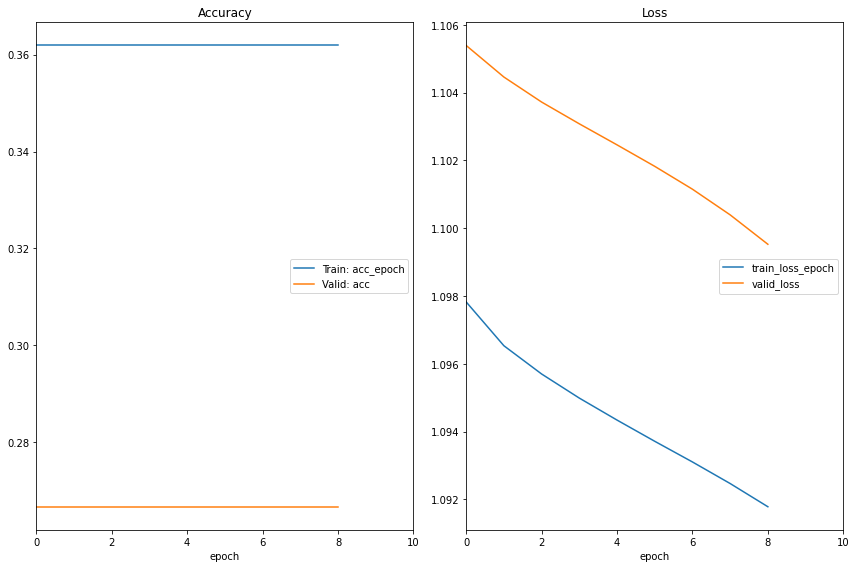

In [13]:
# <<<<<<< /Users/woojincha/Desktop/test/mytest/iris_classification_advanced.ipynb-current
max_epoch = 10
# =======
# max_epoch = 20
# >>>>>>> /Users/woojincha/Desktop/test/mytest/iris_classification_advanced.ipynb-incoming
logger = PlotLossesLogger(
    groups={"loss": ["train_loss_epoch", "valid_loss"], "Accuracy": ["Train: acc_epoch", "Valid: acc"]},
    max_epoch=max_epoch,
)
trainer = pl.Trainer(max_epochs=max_epoch, logger=[logger], enable_progress_bar=False)
trainer.fit(model, train_loader, valid_loader)

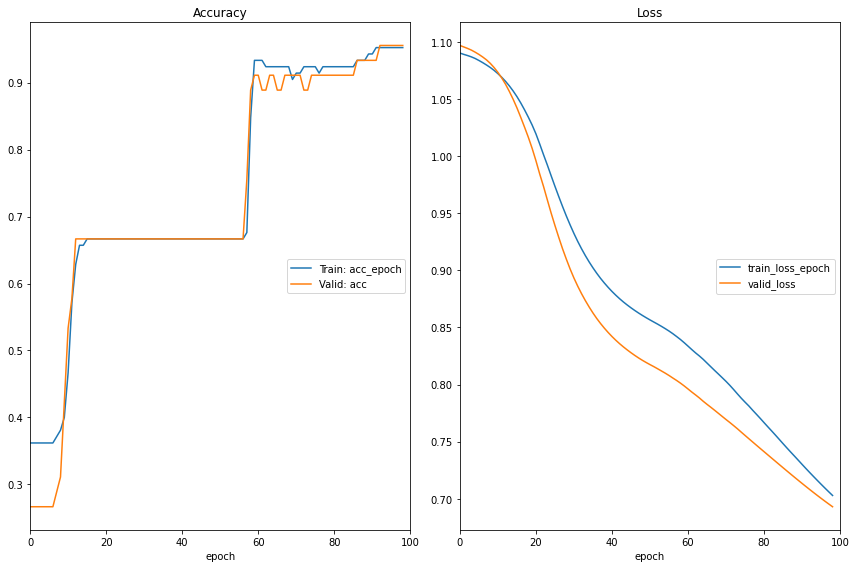

In [10]:
max_epoch = 100
logger = PlotLossesLogger(
    groups={"loss": ["train_loss_epoch", "valid_loss"], "Accuracy": ["Train: acc_epoch", "Valid: acc"]},
    max_epoch=max_epoch,
)
trainer = pl.Trainer(max_epochs=max_epoch, logger=[logger], enable_progress_bar=False)
trainer.fit(model, train_loader, valid_loader)

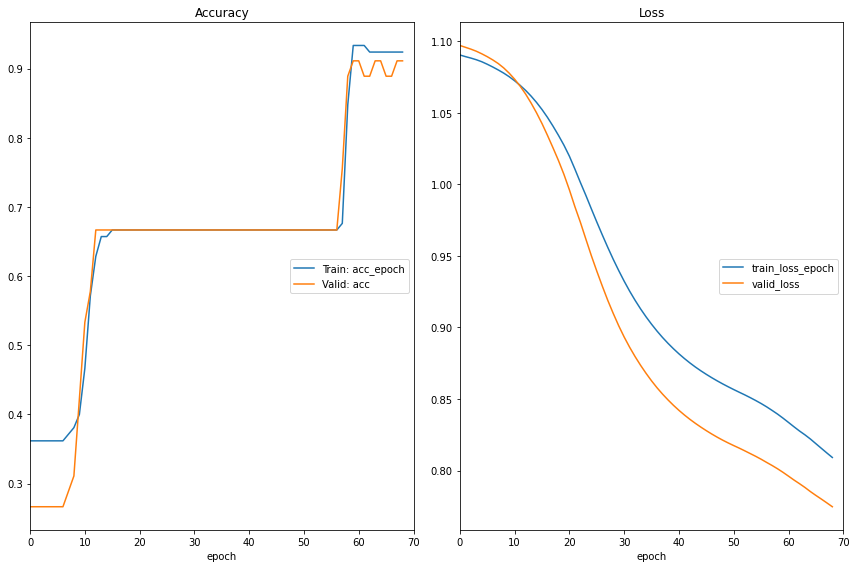

In [11]:
max_epoch = 70
logger = PlotLossesLogger(
    groups={"loss": ["train_loss_epoch", "valid_loss"], "Accuracy": ["Train: acc_epoch", "Valid: acc"]},
    max_epoch=max_epoch,
)
trainer = pl.Trainer(max_epochs=max_epoch, logger=[logger], enable_progress_bar=False)
trainer.fit(model, train_loader, valid_loader)

In [1]:
git add -A

SyntaxError: invalid syntax (2217721594.py, line 1)

In [ ]:
git commit -m "asdf"